# モデル学習

## Library Import

In [1]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

import datetime as dt

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../input/'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
intermediate_path = '../output/intermediate_file/'
model_path = '../output/model/'
oof_path = '../output/oof/'
fi_path = '../output/fi/'

# スクリプトのバージョン指定
fe_ver = 3
training_ver = 6
run_ver = 3 # モデル変更のない特徴量の更新についてはこちらで管理

today = dt.datetime.today().strftime("%Y%m%d")

## File Import

In [3]:
train_df = pd.read_parquet(f'{intermediate_path}train_df_fe_v{fe_ver}.parquet')

In [4]:
date_col = 'target_ym'
target_col = 'money_room'

## 使用特徴量の選択

In [5]:
fe_cols = train_df.columns.to_list()
fe_cols.remove(target_col)

#### カテゴリ型へ変更

In [6]:
cat_cols = ['building_category', 'land_area_kind', 'walk_distance_bin', 'building_land_chimoku',
            'land_chisei','land_road_cond', 'access_zone', 'fireproof_x_structure', 'structure_group'
]

train_df[cat_cols] = train_df[cat_cols].astype('category')

In [7]:
# すべての category 列のリスト
obj_cols = train_df.select_dtypes(['object']).columns.tolist()
train_df[obj_cols] = train_df[obj_cols].astype('category')
cat_cols += obj_cols

## モデルの学習

In [8]:
# --- 東京23区 ---
TOKYO_23 = [
    '千代田区', '中央区', '港区', '新宿区', '文京区', '台東区',
    '墨田区', '江東区', '品川区', '目黒区', '大田区', '世田谷区',
    '渋谷区', '中野区', '杉並区', '豊島区', '北区', '荒川区',
    '板橋区', '練馬区', '足立区', '葛飾区', '江戸川区'
]

# --- 政令指定都市 ---
SEIREI_CITIES = [
    '札幌市', '仙台市', 'さいたま市', '千葉市', '横浜市', '川崎市', '相模原市',
    '新潟市', '静岡市', '浜松市', '名古屋市',
    '京都市', '大阪市', '堺市', '神戸市',
    '岡山市', '広島市', '北九州市', '福岡市', '熊本市'
]

# --- 首都圏（都道府県） ---
CAPITAL_PREFS = ['東京都', '神奈川県', '埼玉県', '千葉県']

# --- 県庁所在地（市名のみ） ---
PREF_CAPITALS = [
    '札幌市','青森市','盛岡市','仙台市','秋田市','山形市','福島市',
    '水戸市','宇都宮市','前橋市','さいたま市','千葉市','新宿区',
    '横浜市','新潟市','富山市','金沢市','福井市','甲府市','長野市',
    '岐阜市','静岡市','名古屋市','津市','大津市','京都市','大阪市',
    '神戸市','奈良市','和歌山市','鳥取市','松江市','岡山市','広島市',
    '山口市','徳島市','高松市','松山市','高知市','福岡市','佐賀市',
    '長崎市','熊本市','大分市','宮崎市','鹿児島市','那覇市'
]

In [9]:
def add_urban_class(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    cond_main = (
        ((out['Prefecture name'] == '東京都') &
         (out['City/town/village name'].isin(TOKYO_23)))
        |
        (out['City/town/village name'].isin(['大阪市', '名古屋市']))
    )

    cond_mid = (
        (
            (out['Prefecture name'].isin(CAPITAL_PREFS))
            &
            ~(
                (out['Prefecture name'] == '東京都') &
                (out['City/town/village name'].isin(TOKYO_23))
            )
        )
        |
        (out['City/town/village name'].isin(SEIREI_CITIES))
        |
        (out['City/town/village name'].isin(PREF_CAPITALS))
    )

    out['UrbanClass'] = 'other'
    out.loc[cond_mid, 'UrbanClass'] = 'mid_city'
    out.loc[cond_main, 'UrbanClass'] = 'main_city'

    out['UrbanClass'] = out['UrbanClass'].astype('category')
    return out


def add_density_class(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # 既存ロジックをそのまま列化
    out['DensityClass'] = 'high'
    out.loc[out['zone_residential_rank'] == 1, 'DensityClass'] = 'low'
    out.loc[out['zone_residential_rank'] == 2, 'DensityClass'] = 'mid'
    # rank in [3,4,0] or NA は high（デフォルト）で一致

    out['DensityClass'] = out['DensityClass'].astype('category')
    return out


In [10]:
train_df = add_urban_class(train_df)
train_df = add_density_class(train_df)

In [11]:
train_df['land_dominant'] = (
    (train_df['effective_age'] >= 40) |
    (train_df['effective_age'].isna())
).astype('int8')

In [12]:
house_idx = train_df['building_category'] == 'house'
non_house_idx = ~house_idx

train_df_house = train_df[house_idx]
train_df_all = train_df[non_house_idx]

all_cols = fe_cols.copy()
house_cols = fe_cols.copy()

In [13]:
def build_all_idx_dict(train_df_all: pd.DataFrame) -> dict[str, np.ndarray]:
    idx = train_df_all.index
    d = {}

    for u in ['main_city', 'mid_city', 'other']:
        m_u = (train_df_all['UrbanClass'] == u)
        d[f'all_{u}_land']   = idx[m_u & (train_df_all['land_dominant'] == 1)]
        d[f'all_{u}_noland'] = idx[m_u & (train_df_all['land_dominant'] == 0)]

    return d


def build_house_idx_dict(train_df_house: pd.DataFrame) -> dict[str, np.ndarray]:
    idx = train_df_house.index
    d = {}

    for dcls in ['low', 'mid', 'high']:
        m_d = (train_df_house['DensityClass'] == dcls)
        d[f'house_{dcls}_land']   = idx[m_d & (train_df_house['land_dominant'] == 1)]
        d[f'house_{dcls}_noland'] = idx[m_d & (train_df_house['land_dominant'] == 0)]

    return d


In [14]:
all_idx_dict = build_all_idx_dict(train_df_all)
house_idx_dict = build_house_idx_dict(train_df_house)

In [15]:
for k, v in all_idx_dict.items():
    print(k, type(v), len(v))

for k, v in house_idx_dict.items():
    print(k, type(v), len(v))

all_main_city_land <class 'pandas.core.indexes.base.Index'> 13229
all_main_city_noland <class 'pandas.core.indexes.base.Index'> 31233
all_mid_city_land <class 'pandas.core.indexes.base.Index'> 16941
all_mid_city_noland <class 'pandas.core.indexes.base.Index'> 58847
all_other_land <class 'pandas.core.indexes.base.Index'> 20978
all_other_noland <class 'pandas.core.indexes.base.Index'> 69240
house_low_land <class 'pandas.core.indexes.base.Index'> 11027
house_low_noland <class 'pandas.core.indexes.base.Index'> 36730
house_mid_land <class 'pandas.core.indexes.base.Index'> 7382
house_mid_noland <class 'pandas.core.indexes.base.Index'> 22608
house_high_land <class 'pandas.core.indexes.base.Index'> 18046
house_high_noland <class 'pandas.core.indexes.base.Index'> 57663


In [16]:
year_col = 'target_year'

# LightGBM のベースパラメータ（あなたの設定）
base_params = {
    'lgb': {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'num_leaves': 100,
        'max_depth': -1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1
    },
    'cat': {
        'loss_function': 'RMSE',
        'depth': 8,
        'learning_rate': 0.05,
        'iterations': 2000,
        'l2_leaf_reg': 5,
        'random_seed': 42,
        'early_stopping_rounds': 200,
        'verbose': False,
    }
}

#### 関数

In [17]:
def mape(y_true, y_pred):
    """MAPE計算（%ではなくratio）。"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.clip(y_true, 1e-6, None))

In [18]:
def _infer_te_source_col(te_col: str) -> str:
    # "xxx_te" -> "xxx"
    return te_col[:-3] if te_col.endswith("_te") else te_col

def fit_target_encoding_map(
    s_cat: pd.Series,
    y: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
) -> tuple[pd.Series, float]:
    """
    1列のカテゴリ s_cat をターゲット y で target encoding するための mapping を作る。
    smoothing: 大きいほど全体平均に寄る（過学習防止）
    """
    s_cat = s_cat.astype("object")
    y = y.astype(float)

    prior = float(y.mean())

    stats = (
        pd.DataFrame({"cat": s_cat, "y": y})
          .groupby("cat")["y"]
          .agg(["count", "mean"])
    )

    # count が小さいカテゴリは prior に寄せる（smoothing + min_samples_leaf）
    count = stats["count"].astype(float)
    mean  = stats["mean"].astype(float)

    # smoothing 係数（一般的な ridge-like smoothing）
    # enc = (count*mean + smoothing*prior) / (count + smoothing)
    enc = (count * mean + smoothing * prior) / (count + smoothing)

    # さらに min_samples_leaf 未満は prior へ
    if min_samples_leaf > 1:
        enc[count < min_samples_leaf] = prior

    return enc, prior

def apply_target_encoding(
    s_cat: pd.Series,
    mapping: pd.Series,
    prior: float,
) -> pd.Series:
    s_cat = s_cat.astype("object")
    return s_cat.map(mapping).fillna(prior).astype(float)

def recompute_te_for_fold(
    train_df: pd.DataFrame,
    tr_idx: pd.Index,
    apply_idx_list: list[pd.Index],
    te_cols: list[str],
    y_tr: pd.Series,
    smoothing: float = 50.0,
    min_samples_leaf: int = 1,
    verbose: bool = False,
) -> dict:
    """
    te_cols（例: eki_name1_te）の各列について、
    学習fold（tr_idx）だけでTEをfitし、apply_idx_list の各Indexへ適用する。

    返り値: {te_col: {"src_col":..., "mapping":..., "prior":...}} （必要なら保存用）
    """
    te_meta = {}

    for te_col in te_cols:
        src_col = _infer_te_source_col(te_col)
        if src_col not in train_df.columns:
            if verbose:
                print(f"[WARN] TE元列が見つからないためスキップ: {te_col} (src={src_col})")
            continue

        mapping, prior = fit_target_encoding_map(
            train_df.loc[tr_idx, src_col],
            y_tr.loc[tr_idx],
            smoothing=smoothing,
            min_samples_leaf=min_samples_leaf,
        )

        # 各適用先（train/val/ho など）へ適用
        for idx in apply_idx_list:
            train_df.loc[idx, te_col] = apply_target_encoding(
                train_df.loc[idx, src_col],
                mapping,
                prior
            ).values

        te_meta[te_col] = {"src_col": src_col, "mapping": mapping, "prior": prior}

    return te_meta

In [19]:
def run_cv_by_separate(
    train_df: pd.DataFrame,
    base_cols: list[str],
    target_col: str,
    year_col: str,
    base_params: dict,
    alg: str,
    idx_dict: dict[str, pd.Index],  # ← 追加
    n_splits: int = 5,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
    cat_cols: list=False
):
    """
    都市区分ごとに CV / 最終モデル学習 / HO 予測を行う
    """

    y = train_df[target_col].astype(float)
    y_log = np.log(y)

    results = {}

    te_cols_base = [c for c in base_cols if c.endswith('_te')]

    for split_key, urban_idx in idx_dict.items():
        print(f'\n==============================')
        print(f' Urban class: {split_key}')
        print(f'==============================')

        # --- 年分割 ---
        idx_cv = urban_idx.intersection(train_df.index[train_df[year_col] <= 2021])
        idx_ho = urban_idx.intersection(train_df.index[train_df[year_col] == 2022])

        if len(idx_cv) == 0 or len(idx_ho) == 0:
            print(f'Skip {split_key} (no data)')
            continue

        y_ho = y.loc[idx_ho]

        print(f'CV rows: {len(idx_cv)}')
        print(f'HO rows: {len(idx_ho)}')

        # --- 初期化 ---
        oof_pred_log = pd.Series(np.nan, index=idx_cv, dtype=float)
        ho_pred_log_accum = pd.Series(0.0, index=idx_ho, dtype=float)

        ho_log_by_fold = []
        fi_list = []

        X_cv = train_df.loc[idx_cv, base_cols]
        y_cv_log = y_log.loc[idx_cv]
        groups_cv = train_df.loc[idx_cv, 'building_id']

        gkf = GroupKFold(n_splits=n_splits)

        # ======================
        # CV
        # ======================
        for fold, (tr_pos, va_pos) in enumerate(
            gkf.split(X_cv, y_cv_log, groups_cv), 1
        ):
            print(f'[{split_key}] Fold {fold}')

            tr_idx = idx_cv[tr_pos]
            va_idx = idx_cv[va_pos]

            # --- TE 再計算 ---
            if te_cols_base:
                recompute_te_for_fold(
                    train_df=train_df,
                    tr_idx=tr_idx,
                    apply_idx_list=[tr_idx, va_idx, idx_ho],
                    te_cols=te_cols_base,
                    y_tr=y_log,
                    smoothing=te_smoothing,
                    min_samples_leaf=te_min_samples_leaf,
                )

            # --- 学習 ---
            if alg == 'lgb':
                model = lgb.LGBMRegressor(**base_params[alg])
                model.fit(
                    train_df.loc[tr_idx, base_cols],
                    y_log.loc[tr_idx]
                )
            elif alg == 'cat':
                train_df[cat_cols] = train_df[cat_cols].astype('string').fillna('NA')
                model = CatBoostRegressor(**base_params[alg], cat_features=cat_cols)
                model.fit(
                    train_df.loc[tr_idx, base_cols],
                    y_log.loc[tr_idx]
                )

            # --- OOF ---
            va_pred_log = model.predict(train_df.loc[va_idx, base_cols])
            oof_pred_log.loc[va_idx] = va_pred_log

            # --- HO ---
            ho_pred_log = model.predict(train_df.loc[idx_ho, base_cols])
            ho_pred_log_accum += ho_pred_log / n_splits
            ho_log_by_fold.append(pd.Series(ho_pred_log, index=idx_ho))

            # --- FI ---
            if alg == 'lgb':
                fi_list.append(pd.DataFrame({
                    'feature': base_cols,
                    'importance': model.booster_.feature_importance(importance_type='gain'),
                    'fold': fold,
                    'urban': split_key,
                }))
            elif alg == 'cat':
                fi_list.append(pd.DataFrame({
                    'feature': base_cols,
                    'importance': model.get_feature_importance(type='PredictionValuesChange'),
                    'fold': fold,
                    'urban': split_key,
                }))

        # --- HO uncertainty ---
        ho_log_stack = pd.concat(ho_log_by_fold, axis=1)
        ho_mu = ho_log_stack.mean(axis=1)
        ho_sigma = ho_log_stack.std(axis=1)

        # ======================
        # 最終モデル（全CVデータ）
        # ======================
        print(f'[{split_key}] Final model training')

        if te_cols_base:
            recompute_te_for_fold(
                train_df=train_df,
                tr_idx=idx_cv,
                apply_idx_list=[idx_cv, idx_ho],
                te_cols=te_cols_base,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf,
                verbose=True,
            )

        if alg == 'lgb':
            final_model = lgb.LGBMRegressor(**base_params[alg])
            final_model.fit(
                train_df.loc[idx_cv, base_cols],
                y_log.loc[idx_cv]
            )
        elif alg == 'cat':
            train_df[cat_cols] = train_df[cat_cols].astype('string').fillna('NA')
            final_model = CatBoostRegressor(**base_params[alg], cat_features=cat_cols)
            final_model.fit(
                train_df.loc[idx_cv, base_cols],
                y_log.loc[idx_cv]
            )

        ho_pred_log_final = pd.Series(
            final_model.predict(train_df.loc[idx_ho, base_cols]),
            index=idx_ho
        )

        # ======================
        # 保存
        # ======================
        results[split_key] = {
            'idx_cv': idx_cv,
            'idx_ho': idx_ho,

            'oof_pred_log': oof_pred_log,
            'ho_pred_log_cv_mean': ho_pred_log_accum,
            'ho_pred_log_final': ho_pred_log_final,

            'ho_mu': ho_mu,
            'ho_sigma': ho_sigma,

            'final_model': final_model,
            'fi': pd.concat(fi_list, ignore_index=True),
        }

    return results

#### house以外モデル

In [20]:
results_all = run_cv_by_separate(
    train_df=train_df_all,
    base_cols=all_cols,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=all_idx_dict,
    cat_cols=cat_cols,  # catboost使うなら
)


 Urban class: all_main_city_land
CV rows: 9380
HO rows: 3849
[all_main_city_land] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29494
[LightGBM] [Info] Number of data points in the train set: 7504, number of used features: 329
[LightGBM] [Info] Start training from score 17.205426
[all_main_city_land] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categori

In [21]:
print('=== OOF MAPE by urban class ===')

for urban_key, res in results_all.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_all.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by urban class (final model) ===')

for urban_key, res in results_all.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_all.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（all）
# =====================
oof_log_all = pd.concat(
    [res['oof_pred_log'] for res in results_all.values()]
).sort_index()

y_oof_all = train_df_all.loc[oof_log_all.index, target_col]
oof_pred_all = np.exp(oof_log_all)

oof_mape_all = mape(y_oof_all, oof_pred_all)
print(f'OOF MAPE (all, 2019–2021): {oof_mape_all:.6f}')

# =====================
# HO MAPE（all, final model）
# =====================
ho_log_all = pd.concat(
    [res['ho_pred_log_final'] for res in results_all.values()]
).sort_index()

y_ho_all = train_df_all.loc[ho_log_all.index, target_col]
ho_pred_all = np.exp(ho_log_all)

ho_mape_all = mape(y_ho_all, ho_pred_all)
print(f'HO MAPE (all, final model): {ho_mape_all:.6f}')

=== OOF MAPE by urban class ===
all_main_city_land | OOF MAPE: 0.184202
all_main_city_noland | OOF MAPE: 0.134694
all_mid_city_land | OOF MAPE: 0.207630
all_mid_city_noland | OOF MAPE: 0.145082
all_other_land | OOF MAPE: 0.238376
all_other_noland | OOF MAPE: 0.159486

=== HO MAPE by urban class (final model) ===
all_main_city_land | HO MAPE: 0.162941
all_main_city_noland | HO MAPE: 0.126697
all_mid_city_land | HO MAPE: 0.188795
all_mid_city_noland | HO MAPE: 0.141371
all_other_land | HO MAPE: 0.185980
all_other_noland | HO MAPE: 0.130370
OOF MAPE (all, 2019–2021): 0.164329
HO MAPE (all, final model): 0.146507


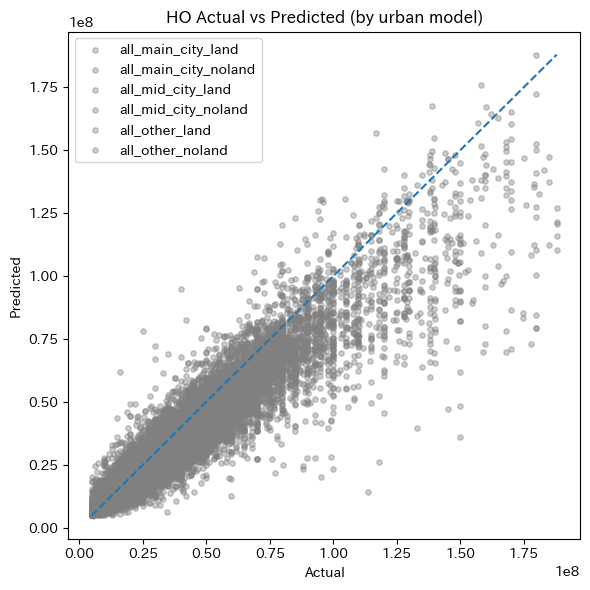

In [22]:
plt.figure(figsize=(6, 6))

color_map = {
    'main_city': 'tab:red',
    'mid_city':  'tab:blue',
    'other':     'tab:green',
}

for urban_key, res in results_all.items():
    idx_ho = res['idx_ho']
    y_true = train_df_all.loc[idx_ho, target_col]
    y_pred = np.exp(res['ho_pred_log_final'])

    plt.scatter(
        y_true,
        y_pred,
        alpha=0.4,
        s=15,
        label=urban_key,
        color=color_map.get(urban_key, 'gray'),
    )

# ===== 45度線 =====
all_y = pd.concat([
    train_df_all.loc[res['idx_ho'], target_col]
    for res in results_all.values()
])

all_pred = pd.concat([
    np.exp(res['ho_pred_log_final'])
    for res in results_all.values()
])

min_val = min(all_y.min(), all_pred.min())
max_val = max(all_y.max(), all_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle='--',
)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('HO Actual vs Predicted (by urban model)')
plt.legend()
plt.tight_layout()
plt.show()

#### houseモデル

In [23]:
results_house = run_cv_by_separate(
    train_df=train_df_house,
    base_cols=house_cols,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=house_idx_dict,
    cat_cols=cat_cols
)


 Urban class: house_low_land
CV rows: 8043
HO rows: 2984
[house_low_land] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34404
[LightGBM] [Info] Number of data points in the train set: 6434, number of used features: 314
[LightGBM] [Info] Start training from score 16.535817
[house_low_land] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGB

In [24]:
print('=== OOF MAPE by density class ===')

for density_key, res in results_house.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_house.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{density_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by density class (final model) ===')

for density_key, res in results_house.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_house.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{density_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（house）
# =====================
oof_log_house = pd.concat(
    [res['oof_pred_log'] for res in results_house.values()]
).sort_index()

y_oof_house = train_df_house.loc[oof_log_house.index, target_col]
oof_pred_house = np.exp(oof_log_house)

oof_mape_house = mape(y_oof_house, oof_pred_house)
print(f'OOF MAPE (house, 2019–2021): {oof_mape_house:.6f}')

# =====================
# HO MAPE（house, final model）
# =====================
ho_log_house = pd.concat(
    [res['ho_pred_log_final'] for res in results_house.values()]
).sort_index()

y_ho_house = train_df_house.loc[ho_log_house.index, target_col]
ho_pred_house = np.exp(ho_log_house)

ho_mape_house = mape(y_ho_house, ho_pred_house)
print(f'HO MAPE (house, final model): {ho_mape_house:.6f}')

=== OOF MAPE by density class ===
house_low_land | OOF MAPE: 0.260171
house_low_noland | OOF MAPE: 0.163046
house_mid_land | OOF MAPE: 0.283134
house_mid_noland | OOF MAPE: 0.169133
house_high_land | OOF MAPE: 0.291577
house_high_noland | OOF MAPE: 0.181686

=== HO MAPE by density class (final model) ===
house_low_land | HO MAPE: 0.212119
house_low_noland | HO MAPE: 0.146367
house_mid_land | HO MAPE: 0.210497
house_mid_noland | HO MAPE: 0.149283
house_high_land | HO MAPE: 0.216952
house_high_noland | HO MAPE: 0.150803
OOF MAPE (house, 2019–2021): 0.197508
HO MAPE (house, final model): 0.166755


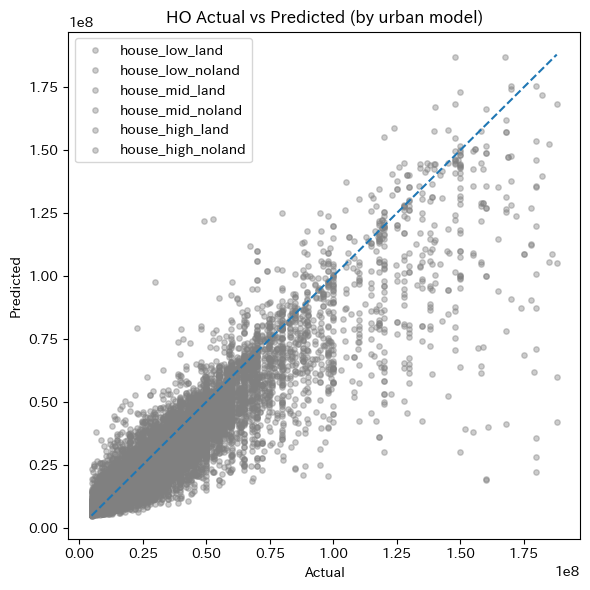

In [25]:
plt.figure(figsize=(6, 6))

color_map = {
    'low':  'tab:red',
    'mid':  'tab:blue',
    'high': 'tab:green',
}

for urban_key, res in results_house.items():
    idx_ho = res['idx_ho']
    y_true = train_df_house.loc[idx_ho, target_col]
    y_pred = np.exp(res['ho_pred_log_final'])

    plt.scatter(
        y_true,
        y_pred,
        alpha=0.4,
        s=15,
        label=urban_key,
        color=color_map.get(urban_key, 'gray'),
    )

# ===== 45度線 =====
house_y = pd.concat([
    train_df_house.loc[res['idx_ho'], target_col]
    for res in results_house.values()
])

house_pred = pd.concat([
    np.exp(res['ho_pred_log_final'])
    for res in results_house.values()
])

min_val = min(house_y.min(), house_pred.min())
max_val = max(house_y.max(), house_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle='--',
)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('HO Actual vs Predicted (by urban model)')
plt.legend()
plt.tight_layout()
plt.show()

## 特徴量重要度

In [26]:
all_base_fi_by_urban = {}

for urban_key, res in results_all.items():
    fi_df_raw = res['fi']  # ← これは DataFrame

    fi_df = (
        fi_df_raw
        .groupby('feature', as_index=False)['importance']
        .mean()
        .sort_values('importance', ascending=False)
    )

    all_base_fi_by_urban[urban_key] = fi_df
    print(urban_key)
    display(all_base_fi_by_urban[urban_key].head(20))


house_base_fi_by_density = {}

for density_key, res in results_house.items():
    fi_df_raw = res['fi']  # ← DataFrame

    fi_df = (
        fi_df_raw
        .groupby('feature', as_index=False)['importance']
        .mean()
        .sort_values('importance', ascending=False)
    )

    house_base_fi_by_density[density_key] = fi_df
    print(density_key)
    display(house_base_fi_by_density[density_key].head(20))


all_main_city_land


,feature,importance
156,madori_kind_all,3188.144765
182,money_kyoueki_std,2105.322664
231,senyu_area_log,1884.512226
53,eki_name1_te,1766.507052
183,money_shuuzen,658.572504
23,building_senyu_area_median,623.850397
118,land_theoretical_price_weighted,619.544530
229,score_building,602.322589
52,eki_name1,583.320598
117,land_theoretical_price,350.999504


all_main_city_noland


,feature,importance
156,madori_kind_all,13317.285558
231,senyu_area_log,6033.542666
182,money_kyoueki_std,5931.749944
53,eki_name1_te,4032.925705
151,log_weighted_land_price_3_x_livability_score,3406.511449
147,log_weighted_land_price_3_x_age_decay_30,2000.734010
52,eki_name1,1826.087224
164,mean_price_1000m_log,1315.932885
23,building_senyu_area_median,997.647914
265,year_built,928.563101


all_mid_city_land


,feature,importance
53,eki_name1_te,8409.449418
118,land_theoretical_price_weighted,2194.623166
117,land_theoretical_price,2155.780381
194,premium_equipment_count,1572.176753
148,log_weighted_land_price_3_x_effective_age,1054.072853
151,log_weighted_land_price_3_x_livability_score,1051.432558
156,madori_kind_all,1047.160950
147,log_weighted_land_price_3_x_age_decay_30,1003.594892
231,senyu_area_log,902.577525
0,City/town/village name,743.383664


all_mid_city_noland


,feature,importance
147,log_weighted_land_price_3_x_age_decay_30,16752.354545
140,log_land_price_x_age_decay_30,13963.030290
151,log_weighted_land_price_3_x_livability_score,6558.290021
53,eki_name1_te,5350.082158
156,madori_kind_all,5237.815904
231,senyu_area_log,4737.070521
52,eki_name1,4012.407610
0,City/town/village name,3564.656418
174,mean_price_500m_mansion_log,2559.419036
165,mean_price_1000m_mansion_log,2549.059912


all_other_land


,feature,importance
53,eki_name1_te,9156.856800
118,land_theoretical_price_weighted,3951.021725
194,premium_equipment_count,2091.575987
117,land_theoretical_price,2090.357668
156,madori_kind_all,1842.249199
151,log_weighted_land_price_3_x_livability_score,1341.868216
135,land_theoretical_price_x_livability_score,1184.650789
182,money_kyoueki_std,933.404215
147,log_weighted_land_price_3_x_age_decay_30,917.782482
0,City/town/village name,897.403585


all_other_noland


,feature,importance
147,log_weighted_land_price_3_x_age_decay_30,27704.955513
140,log_land_price_x_age_decay_30,14786.364583
156,madori_kind_all,10303.673688
151,log_weighted_land_price_3_x_livability_score,8789.389110
53,eki_name1_te,8180.298078
231,senyu_area_log,6448.512511
0,City/town/village name,6318.228432
52,eki_name1,4231.829047
182,money_kyoueki_std,3813.078465
144,log_land_price_x_livability_score,2853.734939


house_low_land


,feature,importance
118,land_theoretical_price_weighted,10556.391241
53,eki_name1_te,2880.921354
117,land_theoretical_price,2419.626556
51,effective_land_price,1620.526314
124,land_theoretical_price_weighted_x_senyu,475.980762
13,area_per_room,412.306011
55,eki_name2_te,356.776174
136,land_theoretical_price_x_senyu,356.205869
156,madori_kind_all,292.511267
229,score_building,227.935987


house_low_noland


,feature,importance
118,land_theoretical_price_weighted,24979.346338
117,land_theoretical_price,7830.913320
51,effective_land_price,7140.984038
131,land_theoretical_price_x_age_decay_30,4044.043577
119,land_theoretical_price_weighted_x_age_decay_30,3082.809192
124,land_theoretical_price_weighted_x_senyu,2095.507486
53,eki_name1_te,1936.901189
0,City/town/village name,1731.360165
136,land_theoretical_price_x_senyu,1101.159174
147,log_weighted_land_price_3_x_age_decay_30,890.983064


house_mid_land


,feature,importance
53,eki_name1_te,5054.450582
118,land_theoretical_price_weighted,2236.572771
117,land_theoretical_price,1339.691016
136,land_theoretical_price_x_senyu,541.421710
51,effective_land_price,411.455674
55,eki_name2_te,373.117664
124,land_theoretical_price_weighted_x_senyu,310.780511
13,area_per_room,229.043823
1,City/town/village name_te,190.511996
156,madori_kind_all,173.512953


house_mid_noland


,feature,importance
118,land_theoretical_price_weighted,15427.444394
117,land_theoretical_price,3985.750584
131,land_theoretical_price_x_age_decay_30,3544.165000
53,eki_name1_te,2359.228404
119,land_theoretical_price_weighted_x_age_decay_30,2290.941497
136,land_theoretical_price_x_senyu,1367.591146
124,land_theoretical_price_weighted_x_senyu,1300.823943
51,effective_land_price,1041.204941
140,log_land_price_x_age_decay_30,786.965111
0,City/town/village name,674.015470


house_high_land


,feature,importance
53,eki_name1_te,11450.538789
118,land_theoretical_price_weighted,4286.143544
51,effective_land_price,3046.889864
117,land_theoretical_price,1988.872556
55,eki_name2_te,1070.307406
1,City/town/village name_te,980.130542
124,land_theoretical_price_weighted_x_senyu,765.842235
136,land_theoretical_price_x_senyu,690.381103
156,madori_kind_all,606.081025
0,City/town/village name,600.418103


house_high_noland


,feature,importance
53,eki_name1_te,15116.832334
151,log_weighted_land_price_3_x_livability_score,14590.872142
118,land_theoretical_price_weighted,14558.629364
124,land_theoretical_price_weighted_x_senyu,8315.103412
147,log_weighted_land_price_3_x_age_decay_30,5888.524342
0,City/town/village name,5289.508522
136,land_theoretical_price_x_senyu,5134.078633
119,land_theoretical_price_weighted_x_age_decay_30,5127.541572
140,log_land_price_x_age_decay_30,3889.499990
51,effective_land_price,3276.636284


In [27]:
all_base_fi_all = (
    pd.concat(
        [
            res['fi'].assign(urban=urban_key)
            for urban_key, res in results_all.items()
        ],
        ignore_index=True,
    )
    .groupby('feature', as_index=False)['importance']
    .mean()
    .sort_values('importance', ascending=False)
)

house_base_fi_all = (
    pd.concat(
        [
            res['fi'].assign(density=density_key)
            for density_key, res in results_house.items()
        ],
        ignore_index=True,
    )
    .groupby('feature', as_index=False)['importance']
    .mean()
    .sort_values('importance', ascending=False)
)

In [28]:
all_base_fi_all.to_csv(f'{fi_path}feature_importance_all_{run_ver}.csv', index=False)
house_base_fi_all.to_csv(f'{fi_path}feature_importance_house_{run_ver}.csv', index=False)

#### 特徴量重要度==0を削除

In [29]:
excluded_fe_all_base = all_base_fi_all.query('importance == 0')['feature'].tolist()
excluded_fe_house_base = house_base_fi_all.query('importance == 0')['feature'].tolist()

print(f'[ALL] Removed {len(excluded_fe_all_base)} features')
print(f'[HOUSE] Removed {len(excluded_fe_house_base)} features')

all_cols_filtered = [c for c in fe_cols if c not in excluded_fe_all_base]
house_cols_filtered = [c for c in fe_cols if c not in excluded_fe_house_base]

[ALL] Removed 59 features
[HOUSE] Removed 85 features


#### house以外モデル

In [30]:
results_all = run_cv_by_separate(
    train_df=train_df_all,
    base_cols=all_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=all_idx_dict,
)


 Urban class: all_main_city_land
CV rows: 9380
HO rows: 3849
[all_main_city_land] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29488
[LightGBM] [Info] Number of data points in the train set: 7504, number of used features: 326
[LightGBM] [Info] Start training from score 17.205426
[all_main_city_land] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categori

In [31]:
print('=== OOF MAPE by urban class ===')

for urban_key, res in results_all.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_all.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by urban class (final model) ===')

for urban_key, res in results_all.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_all.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（all）
# =====================
oof_log_all = pd.concat(
    [res['oof_pred_log'] for res in results_all.values()]
).sort_index()

y_oof_all = train_df_all.loc[oof_log_all.index, target_col]
oof_pred_all = np.exp(oof_log_all)

oof_mape_all = mape(y_oof_all, oof_pred_all)
print(f'OOF MAPE (all, 2019–2021): {oof_mape_all:.6f}')

# =====================
# HO MAPE（all, final model）
# =====================
ho_log_all = pd.concat(
    [res['ho_pred_log_final'] for res in results_all.values()]
).sort_index()

y_ho_all = train_df_all.loc[ho_log_all.index, target_col]
ho_pred_all = np.exp(ho_log_all)

ho_mape_all = mape(y_ho_all, ho_pred_all)
print(f'HO MAPE (all, final model): {ho_mape_all:.6f}')

=== OOF MAPE by urban class ===
all_main_city_land | OOF MAPE: 0.184661
all_main_city_noland | OOF MAPE: 0.134627
all_mid_city_land | OOF MAPE: 0.206871
all_mid_city_noland | OOF MAPE: 0.144669
all_other_land | OOF MAPE: 0.238870
all_other_noland | OOF MAPE: 0.159342

=== HO MAPE by urban class (final model) ===
all_main_city_land | HO MAPE: 0.161623
all_main_city_noland | HO MAPE: 0.126932
all_mid_city_land | HO MAPE: 0.189542
all_mid_city_noland | HO MAPE: 0.141954
all_other_land | HO MAPE: 0.185923
all_other_noland | HO MAPE: 0.130603
OOF MAPE (all, 2019–2021): 0.164166
HO MAPE (all, final model): 0.146719


In [32]:
# === OOF MAPE by urban class ===
# main_city  | OOF MAPE: 0.146815
# mid_city   | OOF MAPE: 0.157506
# other      | OOF MAPE: 0.173965

# === HO MAPE by urban class (final model) ===
# main_city  | HO MAPE: 0.135141
# mid_city   | HO MAPE: 0.152681
# other      | HO MAPE: 0.145625
# OOF MAPE (all, 2019–2021): 0.162293
# HO MAPE (all, final model): 0.145576

#### houseモデル

In [33]:
cat_cols_filtered = [c for c in cat_cols if c not in excluded_fe_house_base]

In [34]:
results_house = run_cv_by_separate(
    train_df=train_df_house,
    base_cols=house_cols_filtered,
    target_col=target_col,
    year_col=year_col,
    alg='lgb',
    base_params=base_params,
    idx_dict=house_idx_dict,
    cat_cols=cat_cols_filtered
)


 Urban class: house_low_land
CV rows: 8043
HO rows: 2984
[house_low_land] Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34404
[LightGBM] [Info] Number of data points in the train set: 6434, number of used features: 314
[LightGBM] [Info] Start training from score 16.535817
[house_low_land] Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGB

In [35]:
print('=== OOF MAPE by urban class ===')

for urban_key, res in results_house.items():
    oof_log = res['oof_pred_log']
    idx_cv  = res['idx_cv']

    y_true = train_df_house.loc[idx_cv, target_col]
    y_pred = np.exp(oof_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | OOF MAPE: {mape_:.6f}')

print('\n=== HO MAPE by urban class (final model) ===')

for urban_key, res in results_house.items():
    ho_log = res['ho_pred_log_final']
    idx_ho = res['idx_ho']

    y_true = train_df_house.loc[idx_ho, target_col]
    y_pred = np.exp(ho_log)

    mape_ = mape(y_true, y_pred)
    print(f'{urban_key:10s} | HO MAPE: {mape_:.6f}')

# =====================
# OOF MAPE（house）
# =====================
oof_log_house = pd.concat(
    [res['oof_pred_log'] for res in results_house.values()]
).sort_index()

y_oof_house = train_df_house.loc[oof_log_house.index, target_col]
oof_pred_house = np.exp(oof_log_house)

oof_mape_house = mape(y_oof_house, oof_pred_house)
print(f'OOF MAPE (house, 2019–2021): {oof_mape_house:.6f}')

# =====================
# HO MAPE（house, final model）
# =====================
ho_log_house = pd.concat(
    [res['ho_pred_log_final'] for res in results_house.values()]
).sort_index()

y_ho_house = train_df_house.loc[ho_log_house.index, target_col]
ho_pred_house = np.exp(ho_log_house)

ho_mape_house = mape(y_ho_house, ho_pred_house)
print(f'HO MAPE (house, final model): {ho_mape_house:.6f}')

=== OOF MAPE by urban class ===
house_low_land | OOF MAPE: 0.260171
house_low_noland | OOF MAPE: 0.163243
house_mid_land | OOF MAPE: 0.283134
house_mid_noland | OOF MAPE: 0.169072
house_high_land | OOF MAPE: 0.291639
house_high_noland | OOF MAPE: 0.181595

=== HO MAPE by urban class (final model) ===
house_low_land | HO MAPE: 0.212119
house_low_noland | HO MAPE: 0.146500
house_mid_land | HO MAPE: 0.210497
house_mid_noland | HO MAPE: 0.148851
house_high_land | HO MAPE: 0.217353
house_high_noland | HO MAPE: 0.151576
OOF MAPE (house, 2019–2021): 0.197520
HO MAPE (house, final model): 0.167064


In [36]:
# === OOF MAPE by urban class ===
# low        | OOF MAPE: 0.180555
# mid        | OOF MAPE: 0.186540
# high       | OOF MAPE: 0.201168

# === HO MAPE by urban class (final model) ===
# low        | HO MAPE: 0.159967
# mid        | HO MAPE: 0.159385
# high       | HO MAPE: 0.168051
# OOF MAPE (house, 2019–2021): 0.191770
# HO MAPE (house, final model): 0.163975

#### 学習データの予測結果出力

In [37]:
# ============================================================
# 1) 予測結果を格納する DataFrame
# ============================================================
train_result_df_all = train_df_all[fe_cols + [target_col]].copy()
train_result_df_house = train_df_house[fe_cols + [target_col]].copy()

train_result_df_all['oof_pred'] = np.nan
train_result_df_all['ho_pred'] = np.nan
train_result_df_house['oof_pred'] = np.nan
train_result_df_house['ho_pred'] = np.nan

# --- HO のマスク（2022年） ---
mask_ho_all = train_result_df_all['target_ym'].astype(str).str.startswith('2022')
mask_ho_house = train_result_df_house['target_ym'].astype(str).str.startswith('2022')

# index が完全一致するのでそのまま代入可
train_result_df_all.loc[~mask_ho_all,     'oof_pred'] = oof_pred_all
train_result_df_all.loc[mask_ho_all,      'ho_pred'] = ho_pred_all
train_result_df_house.loc[~mask_ho_house, 'oof_pred'] = oof_pred_house
train_result_df_house.loc[mask_ho_house,  'ho_pred'] = ho_pred_house

# 保存
train_result_df = pd.concat([train_result_df_all, train_result_df_house], axis=0)
train_result_df.to_csv(f'{oof_path}oof_{today}_{run_ver}.csv', index=False)

## 最終モデル

In [38]:
# 特徴量重要度スコア0の特徴量を除外したモデルのOOFの方がMAPEよければ書き換え
all_base_cols = all_cols_filtered.copy()
house_base_cols = house_cols_filtered.copy()

y_all     = train_df[target_col].astype(float)
y_all_log = np.log(y_all)

# building_category で house / 非 house に分割
idx_non_house = train_df.index[non_house_idx]
idx_house     = train_df.index[house_idx]

In [39]:
def train_final_models_by_split(
    train_df: pd.DataFrame,
    feature_cols: list[str],
    y_log: pd.Series,
    alg: str,
    params: dict,
    idx_dict: dict[str, pd.Index],
    idx: pd.Index | None = None,   # ← 追加（学習母集合の制限）
    cat_cols=None,
    te_smoothing: float = 50.0,
    te_min_samples_leaf: int = 1,
) -> dict[str, lgb.LGBMRegressor]:

    if idx is None:
        idx = train_df.index
    else:
        idx = pd.Index(idx).intersection(train_df.index)  # 念のため母集合を揃える

    models: dict[str, lgb.LGBMRegressor] = {}
    te_cols = [c for c in feature_cols if c.endswith('_te')]

    for split_key, split_idx in idx_dict.items():
        if split_idx is None or len(split_idx) == 0:
            print(f'Skip {split_key} (empty split_idx)')
            continue

        # ★ run_cv_by_separate と同様に必ず交差を取る
        idx_use = pd.Index(split_idx).intersection(idx)

        if len(idx_use) == 0:
            print(f'Skip {split_key} (no rows after intersection)')
            continue

        print(f'=== Final model training: {split_key} | rows={len(idx_use)} ===')

        df_local = train_df.copy()

        # --- split内TE（任意） ---
        if te_cols:
            # split内の母集団 idx_use だけで mapping を作り、idx_use に適用
            # y_tr は y_log をそのまま渡してOK（関数内で tr_idx を参照して使う想定）
            recompute_te_for_fold(
                train_df=df_local,
                tr_idx=idx_use,
                apply_idx_list=[idx_use],
                te_cols=te_cols,
                y_tr=y_log,
                smoothing=te_smoothing,
                min_samples_leaf=te_min_samples_leaf
            )

        X_tr = df_local.loc[idx_use, feature_cols]
        y_tr = y_log.loc[idx_use]

        if alg == 'lgb':
            model = lgb.LGBMRegressor(**params[alg])
            model.fit(X_tr, y_tr)
        elif alg == 'cat':
            # cat_cols は外側スコープ/引数で渡してください
            model = CatBoostRegressor(**params[alg], cat_features=cat_cols)
            model.fit(X_tr, y_tr)
        else:
            raise ValueError(f'Unknown alg: {alg}')

        models[split_key] = model

    return models

In [40]:
final_models_all_by_urban = train_final_models_by_split(
    train_df=train_df_all,
    feature_cols=all_base_cols,
    y_log=np.log(train_df_all[target_col].astype(float)),
    alg='lgb',
    params=base_params,
    idx_dict=all_idx_dict,
    idx=idx_non_house,
)

=== Final model training: all_main_city_land | rows=13229 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31093
[LightGBM] [Info] Number of data points in the train set: 13229, number of used features: 345
[LightGBM] [Info] Start training from score 17.227911
=== Final model training: all_main_city_noland | rows=31233 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_

In [41]:
final_models_house_by_density = train_final_models_by_split(
    train_df=train_df_house,
    feature_cols=house_base_cols,
    y_log=np.log(train_df_house[target_col].astype(float)),
    alg='lgb',
    params=base_params,
    idx_dict=house_idx_dict,
    idx=idx_house,
    cat_cols=cat_cols_filtered
)

=== Final model training: house_low_land | rows=11027 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35794
[LightGBM] [Info] Number of data points in the train set: 11027, number of used features: 325
[LightGBM] [Info] Start training from score 16.549485
=== Final model training: house_low_noland | rows=36730 ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categor

## モデルの出力

In [ ]:
import pickle
from pathlib import Path

def save_model_bundle(
    model_dict: dict,
    base_cols: list,
    cat_cols: list | None,
    save_path: str,
):
    bundle = {
        'models': model_dict,      # ← key ごと丸ごと
        'base_cols': base_cols,
        'cat_cols': cat_cols,
    }

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(bundle, f)

In [47]:
save_model_bundle(
    model_dict=final_models_all_by_urban,
    base_cols=all_cols_filtered,
    cat_cols=None,
    save_path=f'{model_path}/all_model_v{training_ver}.pkl',
)

save_model_bundle(
    model_dict=final_models_house_by_density,
    base_cols=house_cols_filtered,
    cat_cols=cat_cols_filtered,
    save_path=f'{model_path}/house_model_v{training_ver}.pkl',
)

In [ ]:
null_df = (
    pd.DataFrame({
        'null_cnt': train_df.isna().sum(),
        'null_rate': train_df.isna().mean()
    })
    .reset_index()
    .rename(columns={'index': 'feature'})
)

all_fi = (
    all_base_fi_all[['feature', 'importance']]
        .rename(columns={'importance': 'importance_all'})
)

house_fi = (
    house_base_fi_all[['feature', 'importance']]
        .rename(columns={'importance': 'importance_house'})
)

fi_merged = (
    all_fi
        .merge(house_fi, on='feature', how='outer')
        .merge(null_df, on='feature', how='left')
)

fi_merged[['importance_all', 'importance_house']] = (
    fi_merged[['importance_all', 'importance_house']].fillna(0)
)

In [ ]:
candidates = fi_merged[
    ((fi_merged['importance_house'] > 0) | (fi_merged['importance_all'] > 0)) &
    (fi_merged['null_rate'] >= 0.05)
].sort_values(
    ['importance_house', 'importance_all', 'null_rate'],
    ascending=[False, False, False]
)

candidates.head(20)


,feature,importance_all,importance_house,null_cnt,null_rate
118,land_theoretical_price_weighted,901.516362,18854.198289,198347,0.545023
117,land_theoretical_price,736.869652,7268.512502,198347,0.545023
131,land_theoretical_price_x_age_decay_30,0.196455,6890.644001,213082,0.585512
124,land_theoretical_price_weighted_x_senyu,0.000000,6545.075843,210469,0.578332
119,land_theoretical_price_weighted_x_age_decay_30,1.070382,6186.045449,213082,0.585512
136,land_theoretical_price_x_senyu,0.000000,3995.275067,210469,0.578332
123,land_theoretical_price_weighted_x_livability_s...,217.047505,1781.237993,198347,0.545023
135,land_theoretical_price_x_livability_score,128.299340,1583.448619,198347,0.545023
13,area_per_room,172.771684,1276.672406,26052,0.071586
126,land_theoretical_price_within1km_mp_x_age_deca...,0.120287,852.233908,213082,0.585512
